In [1]:
# !pip install -r requirements.txt
%reset -f
import plotly.express as px
from graphviz import Digraph
from itertools import product, combinations
import numpy as np

![](./res/lab-2_system-1.png)

In [35]:
ARRIVAL_RATE = LAMBDA = 1.0 # λ
SERVICE_TIME = B = 1.5
DEPARTURE_RATE = MU = 1 / B # μ
QUEUE_MAX_SIZE = 3
print(f"λ = {LAMBDA}")
print(f"b = {B} ⇒ μ = {MU}")

NUM_SERVERS = N = 3
P_SERVER = [0.6, 0.25, 0.15]
assert len(P_SERVER) == N
assert sum(P_SERVER) == 1

print("\nProbability pi of selecting server i:")
for i, p in enumerate(P_SERVER):
    print(f"p{i + 1} = {p}")

λ = 1.0
b = 1.5 ⇒ μ = 0.6666666666666666

Probability pi of selecting server i:
p1 = 0.6
p2 = 0.25
p3 = 0.15


In [36]:
SERVER_STATES = [IDLE, BUSY] = [0, 1]  # idle / busy
QUEUE_STATES = list(range(0, QUEUE_MAX_SIZE + 1))  # has jobs or empty

SERVERS_STATES_COMBINED = list(product(SERVER_STATES, repeat=N))
ALL_STATES_COMBINED = S = list(product(SERVERS_STATES_COMBINED, QUEUE_STATES))
STATES_INDEX = SI = {s: i for i, s in enumerate(ALL_STATES_COMBINED)}

In [37]:
def make_state_graph(
    allow_simultaneous_job_completion=False,
    allow_simultaneous_queue_departure=False,
    allow_selecting_server_with_probability=True,
    allow_selection_probability_correction=True,
    allow_parellel_service_rate_nonempty_queue=True,
    allow_parellel_service_rate_empty_queue=False,
):
    """
    servers |queue |
    ========+======+
            |#|*|0 |
    --------+-+-+--+
    |(1,1,1)|s|s|sq|
    |   *   |x|x| q|
    |(0,0,0)|x|x| q|

    # = full queue
    * = any middle values
    x = impossible (1)
    s = solved with condition on servers (2), (3)
    q = solved with condition on queue (4)
    """
    transitions_rates = {}  # weighted digraph of transitions between states with rate

    for i, current_state in enumerate(ALL_STATES_COMBINED):
        servers, queue_size = current_state

        transitions_rates[i] = {}

        _all_servers_busy = all(map(lambda s: s == BUSY, servers))
        _all_servers_idle = all(map(lambda s: s == IDLE, servers))
        _full_queue = queue_size == QUEUE_MAX_SIZE
        _empty_queue = queue_size == 0

        if not _empty_queue and not _all_servers_busy:
            """
                (1) Impossible situation in Marcov process: 
                        if in queue there is at least 1 job 
                        then no idle server can exist.
            """
            continue

        if _all_servers_busy:
            """
                (2) When all servers are busy and queue is full
                    we can just drop new jobs or take one job from queue.
                (3) When all servers are busy we can
                        add job to queue
                        or take one job from the queue.
                    In Marcov process we can't do job
                    and add new one to queue at once.
            """
            if not _empty_queue:
                next_state = (servers, queue_size - 1)
                if allow_parellel_service_rate_nonempty_queue:
                    transitions_rates[i][SI[next_state]] = DEPARTURE_RATE * sum(servers)
                else:
                    transitions_rates[i][SI[next_state]] = DEPARTURE_RATE

                if allow_simultaneous_queue_departure:
                    
                    pass

            if not _full_queue:
                next_state = (servers, queue_size + 1)
                transitions_rates[i][SI[next_state]] = ARRIVAL_RATE

        if _empty_queue:
            """
                (4) On empty queue we can 
                        transit each busy server state to idle
                        or load any idle server because of (1).
                
            """
            # complete jobs
            if not _all_servers_idle:
                busy_servers = [j for j, s in enumerate(servers) if s == BUSY]

                for j in busy_servers:
                    next_servers_states = list(servers)
                    next_servers_states[j] = IDLE
                    next_state = (tuple(next_servers_states), queue_size)
                    if allow_parellel_service_rate_empty_queue:
                        transitions_rates[i][SI[next_state]] = DEPARTURE_RATE * sum(servers)
                    else:
                        transitions_rates[i][SI[next_state]] = DEPARTURE_RATE

                if allow_simultaneous_job_completion:
                    for j in range(len(busy_servers)):
                        for complete_servers in combinations(busy_servers, j + 1):
                            next_servers_states = list(servers)
                            for k in complete_servers:
                                next_servers_states[k] = IDLE
                            next_state = (tuple(next_servers_states), queue_size)
                            transitions_rates[i][SI[next_state]] = DEPARTURE_RATE * sum(servers)

            # load idle servers
            if not _all_servers_busy:
                idle_servers = [j for j, s in enumerate(servers) if s == IDLE]
                relative_sum_rate = sum([P_SERVER[j] for j in idle_servers])

                for j in idle_servers:
                    next_servers_states = list(servers)
                    next_servers_states[j] = BUSY
                    next_state = (tuple(next_servers_states), queue_size)

                    if allow_selecting_server_with_probability:
                        if allow_selection_probability_correction:
                            relative_rate = P_SERVER[j] / relative_sum_rate
                        else:
                            relative_rate = P_SERVER[j]
                    else:
                        relative_rate = 1

                    transitions_rates[i][SI[next_state]] = ARRIVAL_RATE * relative_rate

    return {k: v for k, v in transitions_rates.items() if v}


available_states = make_state_graph(
    allow_simultaneous_job_completion=False,
    allow_simultaneous_queue_departure=False,
    allow_selecting_server_with_probability=True,
    allow_selection_probability_correction=True,
    allow_parellel_service_rate_nonempty_queue=True,
    allow_parellel_service_rate_empty_queue=False,
)

for state, transitions in available_states.items():
    print(f"{state}:  {S[state]}")
    for next_state, rate in transitions.items():
        print(f"  [{rate:.4f}]-> {next_state}")

0:  ((0, 0, 0), 0)
  [0.6000]-> 16
  [0.2500]-> 8
  [0.1500]-> 4
4:  ((0, 0, 1), 0)
  [0.6667]-> 0
  [0.7059]-> 20
  [0.2941]-> 12
8:  ((0, 1, 0), 0)
  [0.6667]-> 0
  [0.8000]-> 24
  [0.2000]-> 12
12:  ((0, 1, 1), 0)
  [0.6667]-> 4
  [0.6667]-> 8
  [1.0000]-> 28
16:  ((1, 0, 0), 0)
  [0.6667]-> 0
  [0.6250]-> 24
  [0.3750]-> 20
20:  ((1, 0, 1), 0)
  [0.6667]-> 4
  [0.6667]-> 16
  [1.0000]-> 28
24:  ((1, 1, 0), 0)
  [0.6667]-> 8
  [0.6667]-> 16
  [1.0000]-> 28
28:  ((1, 1, 1), 0)
  [1.0000]-> 29
  [0.6667]-> 12
  [0.6667]-> 20
  [0.6667]-> 24
29:  ((1, 1, 1), 1)
  [2.0000]-> 28
  [1.0000]-> 30
30:  ((1, 1, 1), 2)
  [2.0000]-> 29
  [1.0000]-> 31
31:  ((1, 1, 1), 3)
  [2.0000]-> 30


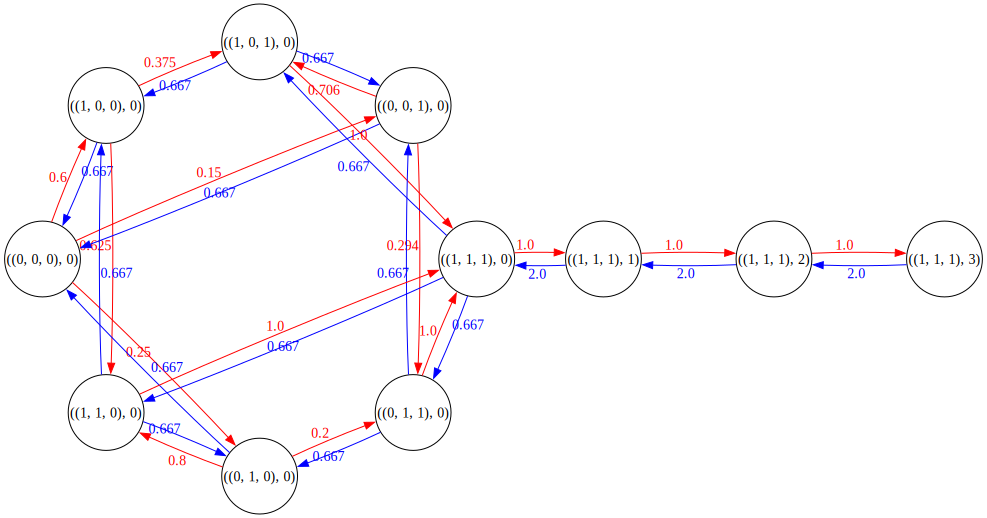

In [38]:
def draw_graph(graph: dict):
    g = Digraph(engine="circo") # engine="sfdp"
    g.attr(overlap="prism") # overlap="scalexy"

    for node, neighbours in graph.items():
        for neighbour, weight in neighbours.items():
            from_id = str(S[node])
            to_id = str(S[neighbour])

            assert weight - 0.001 > 0, f"{weight = }"

            g.node(from_id, from_id, shape="circle", margin="0")

            if sum(S[node][0]) + S[node][1] < sum(S[neighbour][0]) + S[neighbour][1]:
                color = "red" 
            else:
                color = "blue"

            g.edge(from_id, to_id, f"{1.0 * weight:.3}", color=color, fontcolor=color)
    return g


display(draw_graph(available_states))

In [39]:
def make_transition_rate_matrix(graph: dict):
    index = {s: i for i, s in enumerate(graph)}

    n = len(graph)
    matrix = np.zeros((n, n))

    for from_state, to_states in graph.items():
        for to_state, rate in to_states.items():
            matrix[index[from_state], index[to_state]] = rate

    for i in range(n):
        matrix[i, i] = -sum(matrix[i, :])

    return matrix

transition_rate_matrix = make_transition_rate_matrix(available_states)

fig = px.imshow(
    transition_rate_matrix,
    text_auto = True,
    height = 800,
    color_continuous_scale = [[0, 'red'], [0.5, '#f8f8f8'], [1, 'green']],
    color_continuous_midpoint = 0.0,
)
fig.update_layout(
    title='Filtered Transition Rate Matrix',
    xaxis_title='Next State',
    yaxis_title='Current State',
)
fig.show()

In [40]:
def get_probs_of_states(transition_rate_matrix):
    shape = transition_rate_matrix.shape
    assert len(shape) == 2
    assert shape[0] == shape[1]
    n = shape[0]

    equations = transition_rate_matrix.T
    equations[0, :] = np.ones(n)
    bvector = np.zeros(n)
    bvector[0] = 1
    return np.linalg.solve(equations, bvector)


probs = get_probs_of_states(transition_rate_matrix)

for i, (si, p) in enumerate(zip(available_states.keys(), probs)):
    print(f"{i: 3}. {S[si]}:  {p:.6f}")

print(f"\nΣ = {sum(probs)}")

  0. ((0, 0, 0), 0):  0.213689
  1. ((0, 0, 1), 0):  0.072166
  2. ((0, 1, 0), 0):  0.095945
  3. ((0, 1, 1), 0):  0.051663
  4. ((1, 0, 0), 0):  0.152423
  5. ((1, 0, 1), 0):  0.080671
  6. ((1, 1, 0), 0):  0.108066
  7. ((1, 1, 1), 0):  0.120200
  8. ((1, 1, 1), 1):  0.060100
  9. ((1, 1, 1), 2):  0.030050
 10. ((1, 1, 1), 3):  0.015025

Σ = 0.9999999999999999


In [41]:
y = np.array(P_SERVER) * (ARRIVAL_RATE / DEPARTURE_RATE)  # Нагрузка
pbusy = np.zeros(N)  # Загрузка
l = 0  # Длина очереди
m = 0  # Число заявок
loss = 0  # Вероятность потери

prod = np.zeros(N)  # Производительность
wtime = np.zeros(N)  # Время ожидания
ttime = np.zeros(N)  # Время пребывания


for si, prob in zip(available_states.keys(), probs):
    servers, queue_size = S[si]

    pbusy += prob * np.array(servers)
    m += prob * (queue_size + sum(servers))

    l += prob * queue_size  # матожидание длины очереди

    # Probability of loss?
    if queue_size == QUEUE_MAX_SIZE and sum(servers) == 3:
        loss += prob

prod = ARRIVAL_RATE * np.array(P_SERVER) * (1 - loss)
wtime = l / prod
ttime = m / prod

print(f"Нагрузка            y = {y}, Σy = {sum(y):.8}")
print(f"Загрузка            ρ = {pbusy}, Σρ = {sum(pbusy):.8f}, avg(ρ) = {sum(pbusy) / N:.8f}")
print(f"Длина очереди       l = {l:.8f}")  # Очередь единственная
print(f"Число заявок        m = {m:.8f} ")
print(f"Время ожидания      w = {wtime}, Σw {l / sum(prod):.8f}")
print(f"Время пребывания    u = {ttime}, Σu {m / sum(prod):.8f}")
print(f"Вероятность потери  π = {loss:.8f} = {probs[-1]:.8f}")
print(f"Производительность  λ' = {prod}, Σλ' {sum(prod):.8f}")

Нагрузка            y = [0.9   0.375 0.225], Σy = 1.5
Загрузка            ρ = [0.56653606 0.48105027 0.42987611], Σρ = 1.47746244, avg(ρ) = 0.49248748
Длина очереди       l = 0.16527546
Число заявок        m = 1.64273790 
Время ожидания      w = [0.27966102 0.67118644 1.11864407], Σw 0.16779661
Время пребывания    u = [ 2.77966102  6.67118644 11.11864407], Σu 1.66779661
Вероятность потери  π = 0.01502504 = 0.01502504
Производительность  λ' = [0.59098497 0.24624374 0.14774624], Σλ' 0.98497496


[модель системы_1 в GPSS](../lab-3/system_1-model-common.txt)

Эксперимент 1 (старые обозначения)

![](../lab-3/res/system-1_fix_report_variables.png)
![](../lab-3/res/system-1_fix_report_block-hit-rate.png)
![](../lab-3/res/system-1_fix_report_servers.png)
![](../lab-3/res/system-1_fix_report_queues.png)
![](../lab-3/res/system-1_fix_report_multi-chan-servers.png)
![](../lab-3/res/system-1_fix_report_logic.png)

для старой модели

Эксперимент 1

![](../lab-3/res/system-1_report_block-hit-rate.png)
![](../lab-3/res/system-1_report_servers.png)
![](../lab-3/res/system-1_report_queues.png)
![](../lab-3/res/system-1_report_variables.png)

Эксперимент 2 (другие генераторы)

![](../lab-3/res/system-1_report_block-hit-rate_2.png)
![](../lab-3/res/system-1_report_servers_2.png)
![](../lab-3/res/system-1_report_queues_2.png)
![](../lab-3/res/system-1_report_variables_2.png)

In [9]:
!pip freeze > requirements.txt